![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Research to Production
## Principle Component Analysis
---------
### Introduction
This notebook explains how to you can use the Research Environment to develop and test a Principle Component Analysis hypothesis, then put the hypothesis in production.

<a href="https://www.quantconnect.com/docs/v2/research-environment/tutorials/research-to-production/principle-component-analysis">Documentation</a>

### Create Hypothesis
Principal Component Analysis (PCA) a way of mapping the existing dataset into a new "space", where the dimensions of the new data are linearly-independent, orthogonal vectors. PCA eliminates the problem of multicollinearity. In another way of thought, can we actually make use of the collinearity it implied, to find the collinear assets to perform pairs trading?

### Import Libraries
We'll need to import libraries to help with data processing, validation and visualization. Import sklearn, arch, statsmodels, numpy and matplotlib libraries by the following:

In [1]:
from sklearn.decomposition import PCA
from arch.unitroot.cointegration import engle_granger
from statsmodels.tsa.stattools import adfuller
import numpy as np
from matplotlib import pyplot as plt

### Get Historical Data
To begin, we retrieve historical data for research.

In [2]:
# Instantiate a QuantBook.
qb = QuantBook()

# Select the desired tickers for research.
assets = ["SHY", "TLT", "SHV", "TLH", "EDV", "BIL",
          "SPTL", "TBT", "TMF", "TMV", "TBF", "VGSH", "VGIT",
          "VGLT", "SCHO", "SCHR", "SPTS", "GOVT"]

# Call the AddEquity method with the tickers, and its corresponding resolution. Then store their Symbols. Resolution.Minute is used by default. 
for i in range(len(assets)):
    qb.AddEquity(assets[i],Resolution.Minute)

# Call the History method with qb.Securities.Keys for all tickers, time argument(s), and resolution to request historical data for the symbol.
history = qb.History(qb.Securities.Keys, datetime(2021, 1, 1), datetime(2021, 12, 31), Resolution.Daily)
history

close       high        low       open  \
symbol            time                                                     
VGLT UHVG8V7B7YAT 2021-01-05  94.037340  94.322034  93.384507  93.497403   
                  2021-01-06  93.350148  93.654476  92.918198  93.644659   
                  2021-01-07  91.504546  91.887410  91.003877  91.887410   
                  2021-01-08  90.758452  90.902958  90.414856  90.689732   
                  2021-01-09  90.463941  90.758452  90.051625  90.503209   
...                                 ...        ...        ...        ...   
TLO TT1EBZ21QWKL  2021-12-24  42.280000  42.550000  42.140000  42.550000   
                  2021-12-28  42.350000  42.385000  42.220000  42.270000   
                  2021-12-29  42.210000  42.580000  42.130000  42.520000   
                  2021-12-30  41.760000  41.930000  41.690000  41.850000   
                  2021-12-31  42.080000  42.100000  41.705000  41.930000   

                                 volume  
symbol            time                   
VGLT UHVG8V7B7YAT 2021-01-05   347021.0  
                  2021-01-06   291227.0  
                  2021-01-07   476525.0  
                  2021-01-08   672688.0  
                  2021-01-09   297333.0  
...                                 ...  
TLO TT1EBZ21QWKL  2021-12-24  1568824.0  
                  2021-12-28  1256564.0  
                  2021-12-29  1594969.0  
                  2021-12-30  1667772.0  
                  2021-12-31  1371455.0  

[4518 rows x 5 columns]

### Preparing Data
We'll have to process our data to get the principle component unit vector that explains the most variance, then find the highest- and lowest-absolute-weighing assets as the pair, since the lowest one's variance is mostly explained by the highest.

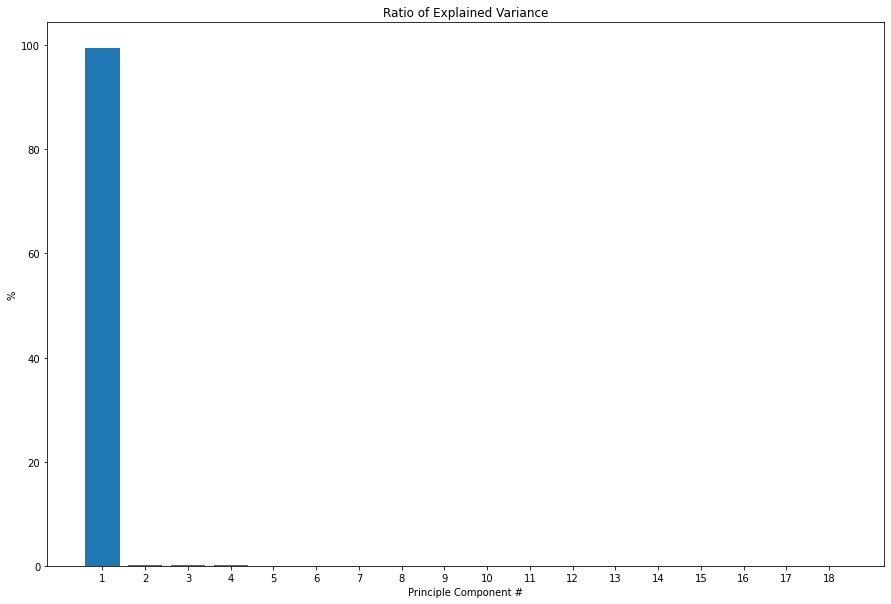

In [3]:
# Select the close column and then call the unstack method.
close_price = history['close'].unstack(level=0)

# Call pct_change to compute the daily return.
returns = close_price.pct_change().iloc[1:]

# Initialize a PCA model, then get the principle components by the maximum likelihood.
pca = PCA()
pca.fit(returns)

# Get the number of principle component in a list, and their corresponding explained variance ratio.
components = [str(x + 1) for x in range(pca.n_components_)]
explained_variance_pct = pca.explained_variance_ratio_ * 100

# Plot the principle components' explained variance ratio.
plt.figure(figsize=(15, 10))
plt.bar(components, explained_variance_pct)
plt.title("Ratio of Explained Variance")
plt.xlabel("Principle Component #")
plt.ylabel("%")
plt.show()

We can see over 95% of the variance is explained by the first principle. We could conclude that collinearity exists and most assets' return are correlated. Now, we can extract the 2 most correlated pairs.

The highest-absolute-weighing asset: SCHO
The lowest-absolute-weighing asset: SHY


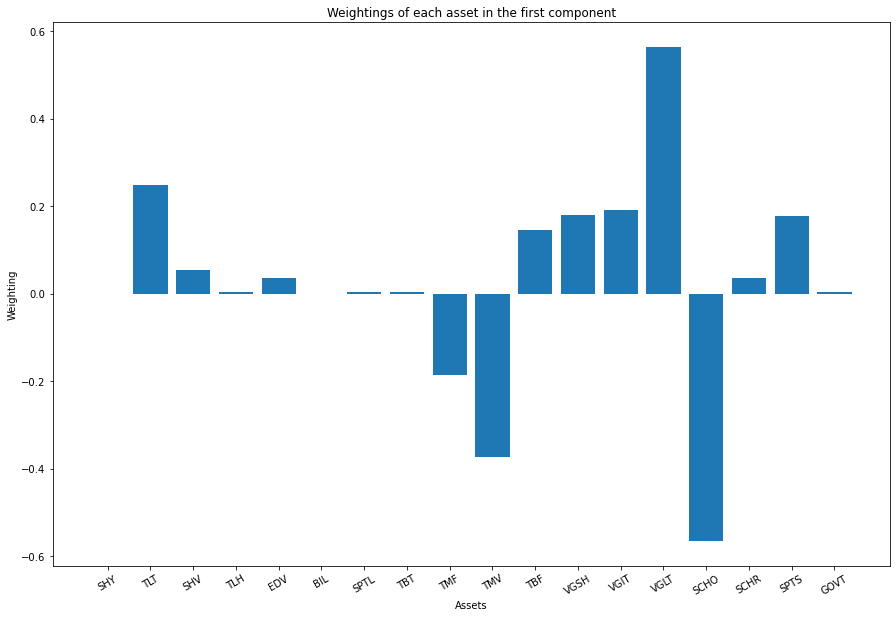

In [4]:
# Get the weighting of each asset in the first principle component.
first_component = pca.components_[0, :]

# Select the highest- and lowest-absolute-weighing asset.
highest = assets[abs(first_component).argmax()]
lowest = assets[abs(first_component).argmin()]
print(f'The highest-absolute-weighing asset: {highest}\nThe lowest-absolute-weighing asset: {lowest}')

# Plot their weighings.
plt.figure(figsize=(15, 10))
plt.bar(assets, first_component)
plt.title("Weightings of each asset in the first component")
plt.xlabel("Assets")
plt.ylabel("Weighting")
plt.xticks(rotation=30)
plt.show()

### Test the Hypothesis
We now selected 2 assets as candidate for pair-trading. Hence, we're going to test if they are cointegrated and their spread is stationary to do so.

Test Statistic,-8.980
P-value,0.000
ADF Lag length,0
Estimated Root ρ (γ+1),0.511


The ADF test p-value is 8.196696196993183e-15, so it is stationary.


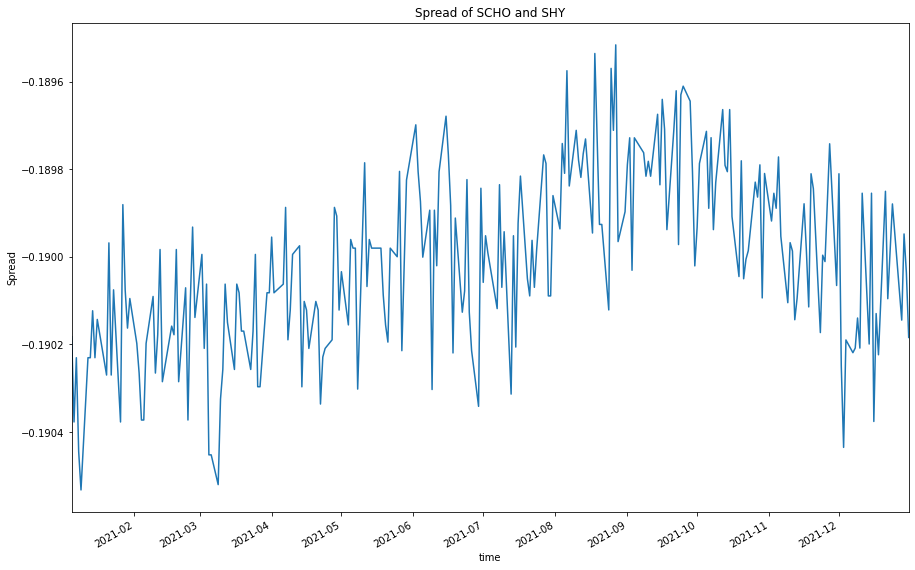

In [5]:
# Call np.log to get the log price of the pair.
log_price = np.log(close_price[[highest, lowest]])

# Test cointegration by Engle Granger Test.
coint_result = engle_granger(log_price.iloc[:, 0], log_price.iloc[:, 1], trend="c", lags=0)
display(coint_result)

# Get their cointegrating vector.
coint_vector = coint_result.cointegrating_vector[:2]

# Calculate the spread.
spread = log_price @ coint_vector

# Use Augmented Dickey Fuller test to test its stationarity.
pvalue = adfuller(spread, maxlag=0)[1]
print(f"The ADF test p-value is {pvalue}, so it is {'' if pvalue < 0.05 else 'not '}stationary.")

# Plot the spread.
spread.plot(figsize=(15, 10), title=f"Spread of {highest} and {lowest}")
plt.ylabel("Spread")
plt.show()

Result shown that the pair is cointegrated and their spread is stationary, so they are potential pair for pair-trading.